In [1]:
import json
import warnings

import geopandas as gpd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import streamlit as st
from tqdm import tqdm
import xarray as xr
import xgboost as xgb

warnings.filterwarnings("ignore")
plt.style.use("seaborn")

# Species Distribution Model: The Regal Sea Goddess!
The Regal Sea Goddess is a type of nudibranch and is one of my favourite creatures I have recently observed in Barcelona's waters. I shall be using data that features one of my very own observations I put on iNaturalist! Here's a picture of one I saw back in August:

<img src="../img/regal_sea_goddess.jpg" width="400">

### 1. Raw Species Data
- Load raw data and ensure all are the right species. Used [this](https://www.gbif.org/occurrence/search?taxon_key=6519348) dataset, downloading the `Simple` version. 
- After very basic filtering, plot raw observations on map. This'll help define the accessible area.
  - Map downloaded from [here](https://www.naturalearthdata.com/downloads/10m-physical-vectors/) - using the coastline map. Decided to maximise resolution here as you can spot a nudibranch super close to the shore. I have personally spotted some ~20m away from the shoreline.

#### 1.1 Data Load and Basic Filtering

In [ ]:
def load_raw_presence_data(filepath):
    df = pd.read_csv(filepath, sep='\t', on_bad_lines="skip")
    print(f"Species Counts: {df['species'].nunique()}")
    print(f"Initial number of rows: {df.shape[0]}")
    return df

def filter_basic_issues_from_dataset(df, coord_uncertainty_threshold=500):
    # 500m uncertainty felt appropriate - I need them close to the shoreline
    # so didn't want to go too high (but also didn't want to filter all out immediately)
    num_to_remove = ((df["coordinateUncertaintyInMeters"] >= coord_uncertainty_threshold) | df["coordinateUncertaintyInMeters"].isna()).sum()
    df = df[df["coordinateUncertaintyInMeters"] < coord_uncertainty_threshold].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on coordinate uncertainty, leaving {df.shape[0]} rows")
    
    # Remove rows with no lat/lon
    num_to_remove = (df["decimalLatitude"].isna() | df["decimalLongitude"].isna()).sum()
    df = df[~(df["decimalLatitude"].isna()) & ~(df["decimalLongitude"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on missing lat/lon, leaving {df.shape[0]} rows")
    df = df.rename(columns={"decimalLatitude": "latitude", "decimalLongitude": "longitude"})
    return df

In [3]:
presence_df = load_raw_presence_data('../data/gbif/raw_rsg_data.csv')
presence_df = filter_basic_issues_from_dataset(presence_df)
presence_df = presence_df[[
    "latitude",
    "longitude",
    "year"
]]
presence_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.longitude, presence_df.latitude),
    crs="EPSG:4326"  # Latitude, longitude, in degrees
)
presence_gdf = presence_gdf.to_crs(epsg=3857)  # Convert to metres for distances
# note that we may want to improve what system to use as it's not perfect for all areas

Species Counts: 1
Initial number of rows: 2647
Filtered out 1866 rows based on coordinate uncertainty, leaving 781 rows
Filtered out 0 rows based on missing lat/lon, leaving 781 rows


#### 1.2 Initial Visualization
- Helps to define appropiate accessible area
- Load in coastline data as map overlay - will also be useful to define distance to shore variable later

In [ ]:
coastline = gpd.read_file("../data/ne_10m_coastline/ne_10m_coastline.shp")

In [5]:
padding=2.0
max_lon = presence_gdf["longitude"].max() + padding
min_lon = presence_gdf["longitude"].min() - padding
max_lat = presence_gdf["latitude"].max() + padding
min_lat = presence_gdf["latitude"].min() - padding

In [6]:
def visualise_data_on_map(coastline, points_dfs=[], points_dfs_colors=[], points_dfs_labels=[], coastline_alpha=1, 
                          plot_bounding_box=True, limit_to_bounding_box=False, accessible_area=None, show_plot=True):
    coastline = coastline.to_crs(epsg=4326)
    coastline.plot(color="black", linewidth=0.5, figsize=(20,10), label="Coastline", alpha=coastline_alpha)
    for i, points_df in enumerate(points_dfs):
        plt.scatter(points_df["longitude"], points_df["latitude"], s=5, label=points_dfs_labels[i], color=points_dfs_colors[i])

    if plot_bounding_box:
        plt.plot([min_lon, min_lon, max_lon, max_lon, min_lon],
                [min_lat, max_lat, max_lat, min_lat, min_lat], color='blue', alpha=0.5, linewidth=1, label="Accessible Area")
        
        # Remove area not well connected to the Med - no observations there anyway
        plt.plot([max_lon, max_lon, max_lon - 6, max_lon - 6, max_lon],
                 [min_lat, min_lat + 13.5, min_lat + 13.5, min_lat, min_lat],
                 color='green', alpha=0.5, linewidth=1, label="Remove from Accessible Area")
    
    if accessible_area is not None:
        accessible_area.plot(
            cmap="Blues",
            alpha=0.4,
            add_colorbar=False,
            label="Accessible Area"
        )
        
    if limit_to_bounding_box:
        plt.xlim(min_lon - 2, max_lon + 2)
        plt.ylim(min_lat - 2, max_lat + 2)

    plt.axis('off')
    if show_plot:
        plt.legend()
        plt.show()

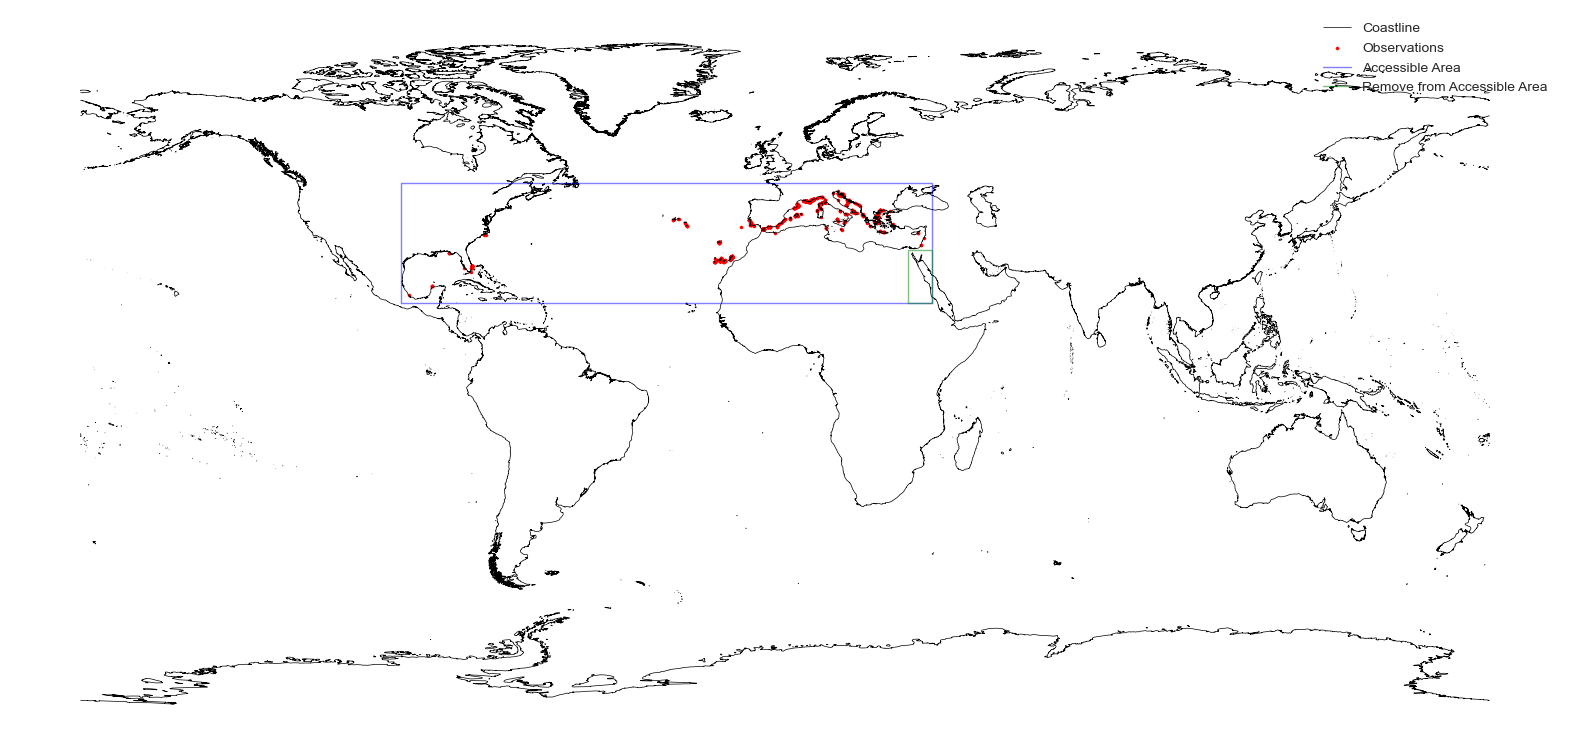

In [7]:
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"])

### 2. Accessible Area Creation
Using the map above and online literature to guide a decent accessible area map. I will use this to:
- Filter presence data to be within this area only
- Sample appropriate background data

Here's what I found:
- Amazingly, it's found on both sides of the Atlantic - including Islands within the Atlantic - and in the Mediterranean. I will be using the above blue rectangle to define the boundary before filtering further on below criteria.
  - Fun fact: It's actually wild that it's found all over, considering it's basically a (brilliant) slug! They have achieved this miraculous feat due to having a very long planktonic phase, so they can be transported by oceanic currents for miles ([source](https://projectmanaia.at/blog/felimare-picta/)).
- This nudibranch is found within a depth of 55m. Due to the location data - and therefore bathymetry - being a little unreliable, I will increase to 1km to allow more data points through.
  - I also considered doing distance to shore but I think the depth may be more important. From the visual below, it seemed sufficient to define a decent accessible area.
- Always in the sea

In [ ]:
def create_accessible_area(ref_coordinate_space_dataset_path="../data/environmental/bio_oracle/bathymetry.nc"):
    """
    Criteria:
    - Within bounding box of all presence data (and a bit of padding)
    - No land
    - Depth shallower than 1000m (nudibranchs are generally shallow water species)
    - Remove area only connected to Med via canal (no presence data there anyway)
    """
    ds = xr.open_dataset(ref_coordinate_space_dataset_path)
    bathy = ds["bathymetry_mean"]

    lons = bathy["longitude"].values
    lats = bathy["latitude"].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    region_mask = (
        (lon2d >= min_lon) & (lon2d <= max_lon) &
        (lat2d >= min_lat) & (lat2d <= max_lat)
    )
    # Remove area only connected to Med via canal
    region_mask[(lon2d >= max_lon - 6) & (lat2d <= min_lat + 13.5)] = False

    ocean_mask = np.isfinite(bathy.values)[0]
    shelf_mask = (bathy.values >= -1000)[0]
    accessible_area_mask = ocean_mask & shelf_mask & region_mask

    accessible_area = xr.DataArray(
        accessible_area_mask.astype(np.uint8),
        coords={"latitude": bathy["latitude"], "longitude": bathy["longitude"]},
        dims=("latitude", "longitude"),
        name="M_accessible"
    )
    return accessible_area_mask, accessible_area

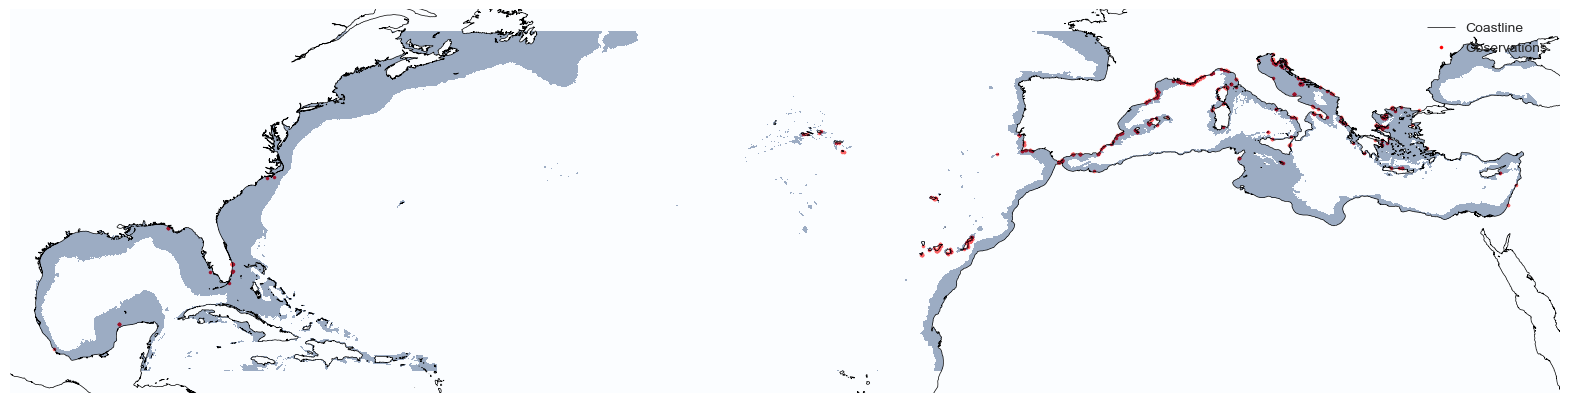

In [9]:
accessible_area_mask, accessible_area = create_accessible_area()
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"], accessible_area=accessible_area,
                      plot_bounding_box=False, limit_to_bounding_box=True)
# Accessible area seems to visually have good overlap with all nudibranch observations!

### 3. Filter Presence Data
- Ensure it is within the accessible area only. This will remove those on land or too deep or outside the bounding box.

In [10]:
def filter_data_to_be_within_accessible_area(gdf):
    gdf = gdf.to_crs(epsg=4326)
    gdf_filtered = gdf[
        gdf.geometry.apply(lambda point: accessible_area.sel(longitude=point.x, latitude=point.y, method="nearest").values == 1)
    ].reset_index(drop=True)
    gdf_removed = gdf[~gdf.index.isin(gdf_filtered.index)].reset_index(drop=True)
    n_removed = gdf.shape[0] - gdf_filtered.shape[0]
    print(f"Filtered out {n_removed} rows based on accessible area, leaving {gdf_filtered.shape[0]} rows")
    return gdf_filtered, gdf_removed

Filtered out 375 rows based on accessible area, leaving 406 rows


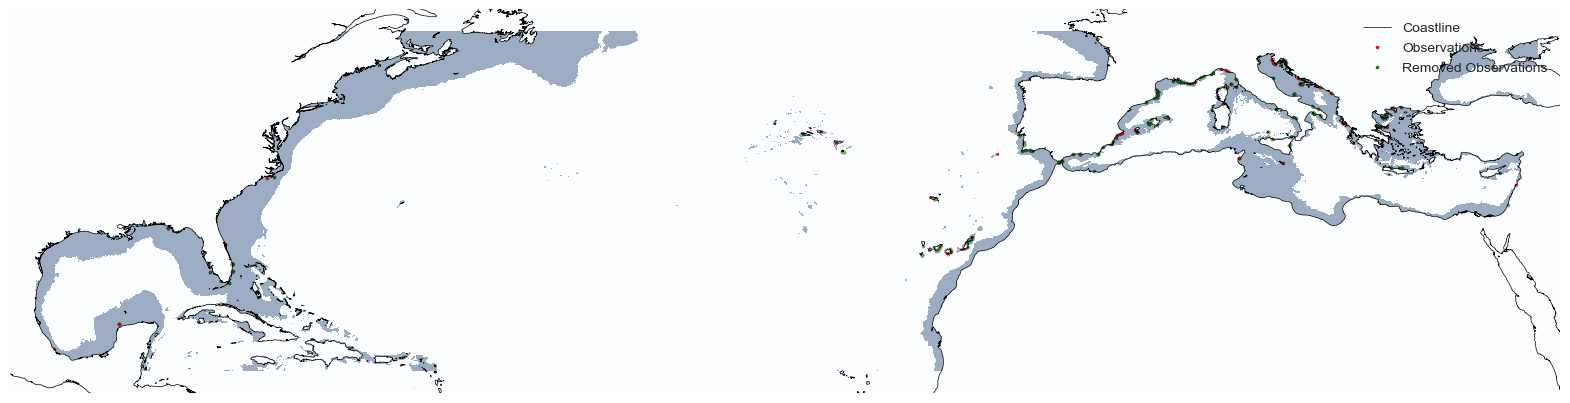

In [11]:
presence_gdf_filtered, presence_gdf_removed = filter_data_to_be_within_accessible_area(presence_gdf)

# Plotting removed points also to see if I didn't capture some important areas/variables
visualise_data_on_map(coastline, [presence_gdf_filtered, presence_gdf_removed], ["red", "green"], ["Observations", "Removed Observations"],
                      accessible_area=accessible_area, plot_bounding_box=False, limit_to_bounding_box=True)

# Note that there are a lot of removed points around some islands - in the future I'd consider swapping bathymetry with distance to shore.
# For proof of concept I am keeping bathymetry as the overlap is generally decent.

### 4. Load Environmental Data
- Using [Bio-ORACLE](https://www.bio-oracle.org/downloads-to-email.php) for the following variables that I believe will be useful:
  - Mean Bathymetry (Depth)
  - Mean Topographic Slope
  - Mean Sea Surface Temperature
  - Range Sea Surface Temperature
  - Mean Chlorophyll-a
  - Mean Salinity
- For all of the above, I selected `Present Day Conditions (2010-2020)` and used `Surface Layers`
- For distance to shore, using [NaturalEarthData](https://www.naturalearthdata.com/downloads/10m-physical-vectors/) coastline map

I have kept to just a few variables due to the small dataset and not wanting to overfit.

In [12]:
# Based on the below, we're okay to use the decade 2010-2020 for the estimate
np.nanpercentile(presence_gdf_filtered["year"], 10), np.nanpercentile(presence_gdf_filtered["year"], 90)

(2013.0, 2024.0)

In [ ]:
def get_variable_based_on_lat_and_lon(ds, var_name, lat, lon):
    return ds[var_name].sel(
        time="1970-01-01", longitude=lon, latitude=lat, method="nearest"
    ).values.item()

bath_ds = xr.open_dataset("../data/environmental/bio_oracle/bathymetry.nc")
presence_gdf_filtered["bathymetry"] = presence_gdf_filtered.apply(lambda row: get_variable_based_on_lat_and_lon
                            (bath_ds, "bathymetry_mean", row["latitude"], row["longitude"]), axis=1)

mean_sst_ds = xr.open_dataset("../data/environmental/bio_oracle/mean_sst.nc")
presence_gdf_filtered["mean_sst"] = presence_gdf_filtered.apply(lambda row: get_variable_based_on_lat_and_lon
                          (mean_sst_ds, "thetao_mean", row["latitude"], row["longitude"]), axis=1)

range_sst_ds = xr.open_dataset("../data/environmental/bio_oracle/range_sst.nc")
presence_gdf_filtered["range_sst"] = presence_gdf_filtered.apply(lambda row: get_variable_based_on_lat_and_lon
                           (range_sst_ds, "thetao_range", row["latitude"], row["longitude"]), axis=1)

salinity_ds = xr.open_dataset("../data/environmental/bio_oracle/salinity.nc")
presence_gdf_filtered["mean_salinity"] = presence_gdf_filtered.apply(lambda row: get_variable_based_on_lat_and_lon
                               (salinity_ds, "so_mean", row["latitude"], row["longitude"]), axis=1)

chloro_ds = xr.open_dataset("../data/environmental/bio_oracle/chlorophyll.nc")
presence_gdf_filtered["mean_chlorophyll_a"] = presence_gdf_filtered.apply(lambda row: get_variable_based_on_lat_and_lon
                                  (chloro_ds, "chl_mean", row["latitude"], row["longitude"]), axis=1)

slope_ds = xr.open_dataset("../data/environmental/bio_oracle/slope.nc")
presence_gdf_filtered["mean_slope"] = presence_gdf_filtered.apply(lambda row: get_variable_based_on_lat_and_lon
                                  (slope_ds, "slope", row["latitude"], row["longitude"]), axis=1)

presence_gdf_filtered = presence_gdf_filtered.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
presence_gdf_filtered["distance_to_shore_m"] = presence_gdf_filtered.geometry.apply(lambda point: coastline.distance(point).min())
presence_gdf_filtered = presence_gdf_filtered.to_crs(epsg=4326)

# Double check if any missing - shouldn't be due to previous filtering on lat/lon
assert presence_gdf_filtered.isna().sum().sum() == 0

### 5. Tackling Sampling Bias
There is an issue for both background data and presence data: observations are biased by where people go - e.g. diving hotspots in this case. Implementing two methods here to deal with this:
- Spatial thinning on presence data
  - One presence data point per 5km to remove sample bias in presence set
- Kernel density estimation for background sampling, using larger dataset
  - Using a large dataset of various observed marine life to build a probability map of where observations typically occur. Then, filtering out to only the accessible area and removing points <5km from nudibranch observations -> background sampling probabilities. This means that locations that are often observed but never see a nudibranch will be picked more often and have a higher chance of being true absence data.

The selection criteria for the density estimation was this, in GBIF:
![](../img/sampling_bias_selection.png)

#### 5.1 Spatial Thinning

In [ ]:
def spatially_thin(gdf, min_distance_m):
    '''
    Spatially thin a dataset so that no points are within min_distance_m of each other.
    Reduces sampling bias for the 'presence' data.
    '''
    gdf = gdf.to_crs(epsg=3857)
    coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
    
    tree = cKDTree(coords)
    to_keep = np.ones(len(gdf), dtype=bool)
    for i in range(len(coords)):
        if to_keep[i]:
            neighbors = tree.query_ball_point(coords[i], r=min_distance_m)
            neighbors.remove(i)
            to_keep[neighbors] = False
    return gdf[to_keep].reset_index(drop=True)

presence_gdf_filtered = spatially_thin(presence_gdf_filtered, 5000).reset_index(drop=True)
print(f"Rows: {presence_gdf_filtered.shape[0]}")

Rows: 166


#### 5.2 Background Sampling Kernel
- Filter poor data in the same way as the presence data
- Filter to accessible area only
- Filter out anything within 5km of nudibranch presence
- Rasterize count per lat/lon
- Apply smoothing
- Change into probability distribution for sampling

In [15]:
def filter_dataset_1_by_distance_to_dataset_2(gdf_1, gdf_2, threshold_m):
    gdf_1 = gdf_1.to_crs(epsg=3857)
    gdf_2 = gdf_2.to_crs(epsg=3857)
    joined = gdf_1.sjoin_nearest(
        gdf_2[['geometry']], 
        how='left', 
        distance_col='dist_m'
    )
    joined = joined.drop_duplicates("gbifID")
    gdf_1 = gdf_1.loc[joined['dist_m'] >= threshold_m].copy()
    return gdf_1


def create_raw_raster(gdf, accessible_area):
    raster = np.zeros_like(accessible_area, dtype=int)
    lons = accessible_area["longitude"].values
    lats = accessible_area["latitude"].values
    for lon, lat in tqdm(zip(gdf["longitude"], gdf["latitude"])):
        lon_idx = np.abs(lons - lon).argmin()
        lat_idx = np.abs(lats - lat).argmin()
        if accessible_area.sel(longitude=lon, latitude=lat, method="nearest").values == 0:
            continue
        raster[lat_idx, lon_idx] += 1
    # Expect large number in a hotspot, median of 0 as most points are empty, but still a decently large amount of non-zero points
    print(f"Raster stats - max: {raster.max()}, median: {np.median(raster)}, non-zero count: {(raster > 0).sum()}")
    return raster


def create_probability_raster(raw_raster, sigma=1):
    prob_raster = gaussian_filter(raw_raster.astype(float), sigma=sigma)
    prob_raster /= prob_raster.sum()
    return prob_raster

In [16]:
background_df = load_raw_presence_data('../data/gbif/background_data.csv')
background_df = filter_basic_issues_from_dataset(background_df)

background_gdf = gpd.GeoDataFrame(
    background_df,
    geometry=gpd.points_from_xy(background_df.longitude, background_df.latitude),
    crs="EPSG:4326"
)
background_df, _ = filter_data_to_be_within_accessible_area(background_gdf)
background_df = filter_dataset_1_by_distance_to_dataset_2(background_df, presence_gdf_filtered, 5000)
bg_raster = create_raw_raster(background_df, accessible_area)
bg_prob_raster = create_probability_raster(bg_raster, sigma=1)

Species Counts: 5733
Initial number of rows: 1326953
Filtered out 15846 rows based on coordinate uncertainty, leaving 1311107 rows
Filtered out 0 rows based on missing lat/lon, leaving 1311107 rows
Filtered out 1067918 rows based on accessible area, leaving 243189 rows


215063it [00:42, 5027.07it/s]


Raster stats - max: 9461, median: 0.0, non-zero count: 5732


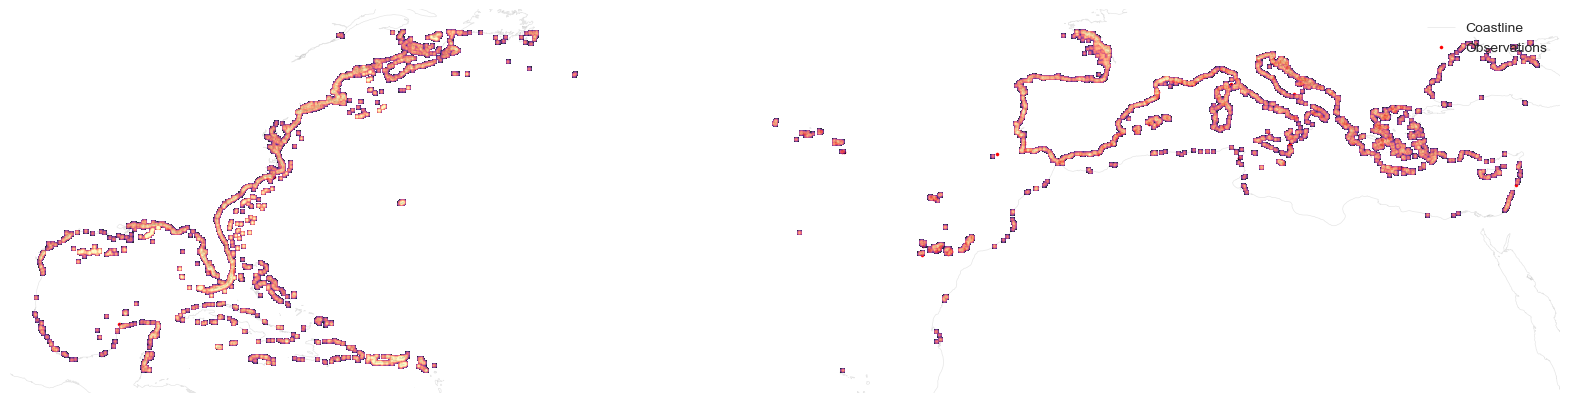

In [17]:
# Visually double check that the probability raster seems to align with expectations
visualise_data_on_map(coastline, [presence_gdf_filtered], ["red"], ["Observations"], coastline_alpha=0.1,
                      plot_bounding_box=False, limit_to_bounding_box=True, show_plot=False)

lons = accessible_area["longitude"].values
lats = accessible_area["latitude"].values
pos_prob_rast = bg_prob_raster[bg_prob_raster > 0]
norm = LogNorm(vmin=1e-12, vmax=np.percentile(pos_prob_rast, 99.5))
plt.gca().pcolormesh(
    lons, lats, bg_prob_raster,
    shading="auto",
    cmap="magma",             
    norm=norm,
    alpha=0.85,
    zorder=1,
    label="Background Sampling Probability (Log Scale)"
)
plt.legend()
plt.show()

### 6. Background Point Selection
- Select ~15k lat + lon points based on sampling kernel
  - Then drop any that don't have environmental data

In [18]:
BG_SIZE = 15000

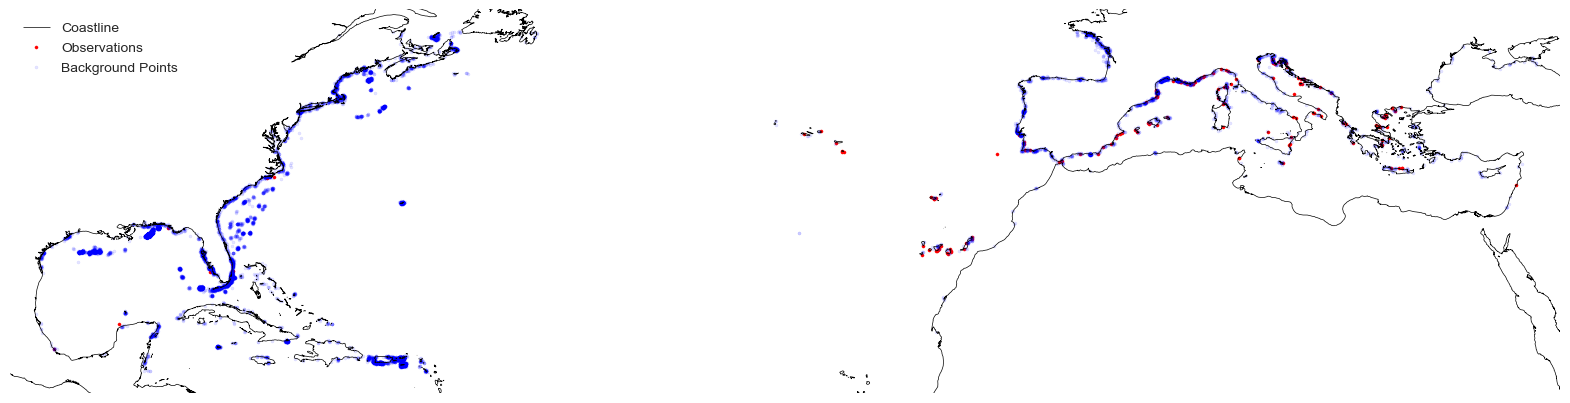

In [19]:
lons = accessible_area["longitude"].values
lats = accessible_area["latitude"].values
np.random.seed(42)
background_points = np.random.choice(
    np.arange(bg_prob_raster.size),
    size=BG_SIZE,
    replace=True,
    p=bg_prob_raster.flatten()
)
background_indices = np.unravel_index(background_points, bg_prob_raster.shape)
background_lons = lons[background_indices[1]]
background_lats = lats[background_indices[0]]

# Visual to ensure there isn't overlap with the sample points and that the background points appear sensible
visualise_data_on_map(coastline, [presence_gdf_filtered], ["red"], ["Observations"],
                      plot_bounding_box=False, limit_to_bounding_box=True, show_plot=False)
plt.scatter(background_lons, background_lats, color='blue', s=5, alpha=0.1, label="Background Points")
plt.legend()
plt.show()


In [20]:
bg_vars = pd.DataFrame({
    "latitude": background_lats,
    "longitude": background_lons
})
bg_vars["bathymetry"] = bg_vars.apply(lambda row: get_variable_based_on_lat_and_lon
                            (bath_ds, "bathymetry_mean", row["latitude"], row["longitude"]), axis=1)
bg_vars["mean_sst"] = bg_vars.apply(lambda row: get_variable_based_on_lat_and_lon
                          (mean_sst_ds, "thetao_mean", row["latitude"], row["longitude"]), axis=1)
bg_vars["range_sst"] = bg_vars.apply(lambda row: get_variable_based_on_lat_and_lon
                           (range_sst_ds, "thetao_range", row["latitude"], row["longitude"]), axis=1)
bg_vars["mean_salinity"] = bg_vars.apply(lambda row: get_variable_based_on_lat_and_lon
                               (salinity_ds , "so_mean", row["latitude"], row["longitude"]), axis=1)
bg_vars["mean_chlorophyll_a"] = bg_vars.apply(lambda row: get_variable_based_on_lat_and_lon
                                  (chloro_ds, "chl_mean", row["latitude"], row["longitude"]), axis=1)
bg_vars["mean_slope"] = bg_vars.apply(lambda row: get_variable_based_on_lat_and_lon
                                  (slope_ds, "slope", row["latitude"], row["longitude"]), axis=1)
bg_vars = bg_vars.dropna().reset_index(drop=True)

gbg_vars = gpd.GeoDataFrame(
    bg_vars,
    geometry=gpd.points_from_xy(bg_vars.longitude, bg_vars.latitude),
    crs="EPSG:4326"
)
gbg_vars = gbg_vars.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857) 
gbg_vars["distance_to_shore_m"] = gbg_vars.geometry.apply(lambda point: coastline.distance(point).min())
gbg_vars = gbg_vars.to_crs(epsg=4326)

print("Background dataset size: ", len(gbg_vars))

Background dataset size:  12696


### 7. Feature Visualisation
- Quick check of if these features will be able to tell apart presence from background
- Findings:
  - Very close to shore and shallow
  - They love their salt!
    - Note that might just be a correlation with distance to shore.
  - Have a sweet spot for temperature
  - Don't care much for chlorophyll-a
  - Two notable groupings of sea temperature range
  - Seem to like their slopes but that might just be some bias in small sample size

- Overall, distribution differences are clearly there, so we should be able to generate a somewhat decent model

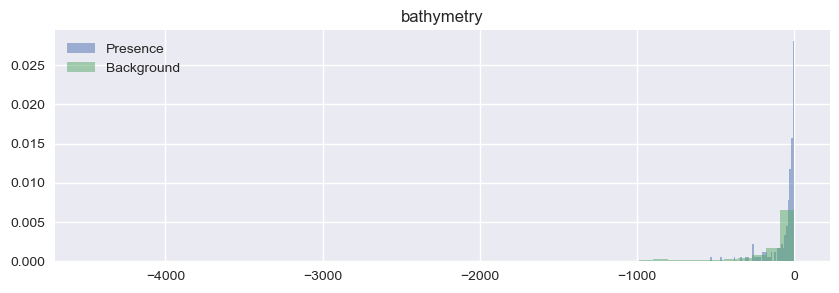

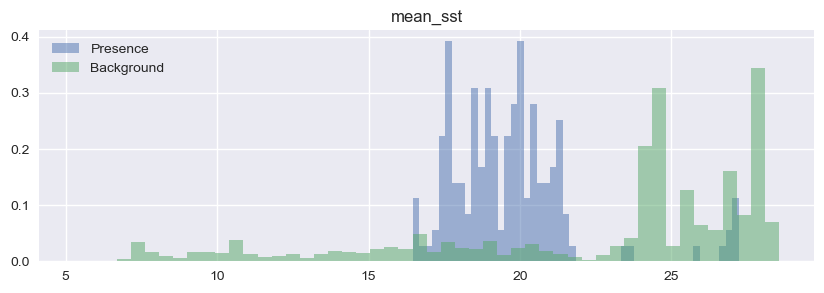

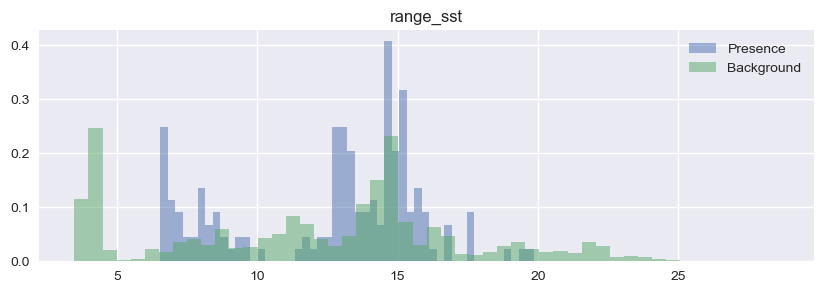

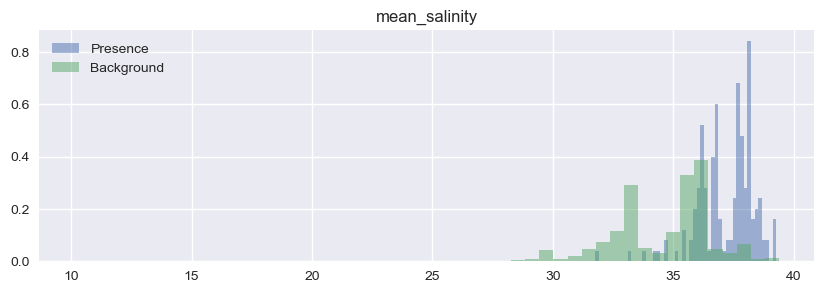

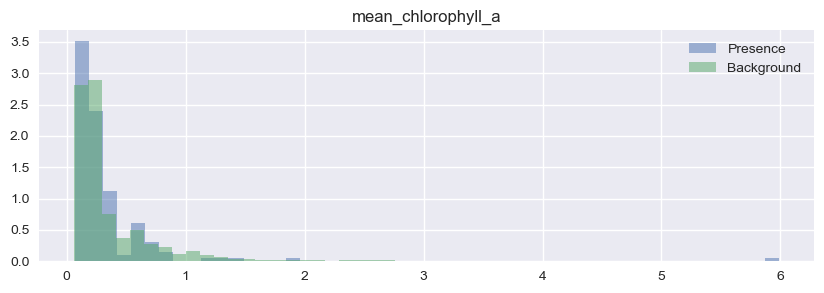

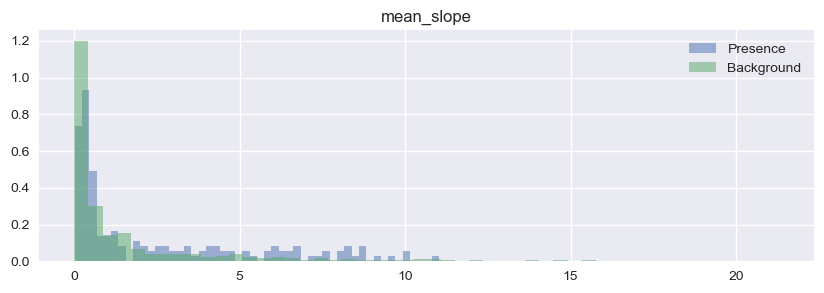

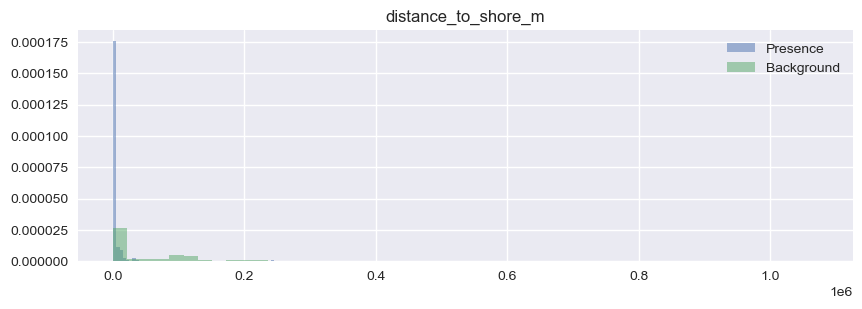

In [21]:
# Check out histograms of variables
PREDICTOR_COLS = [
    "bathymetry",
    "mean_sst",
    "range_sst",
    "mean_salinity",
    "mean_chlorophyll_a",
    "mean_slope",
    "distance_to_shore_m"
]

for predictor in PREDICTOR_COLS:
    plt.figure(figsize=(10, 3))
    plt.hist(presence_gdf_filtered[predictor], bins=50, alpha=0.5, label="Presence", density=True)
    plt.hist(gbg_vars[predictor], bins=50, alpha=0.5, label="Background", density=True)
    plt.title(predictor)
    plt.legend()
    plt.show()

### 8. Modelling with Spatial Cross Validation
- Create spatial folds for all points
- Fit XGBoost model across all folds
- Basic threshold optimisation - use small validation set to find optimal threshold, then evaluate using that on the left out set
- Obtain precision, recall and f1_score for all folds - to evaluate further in the next section

#### 8.1 Prepare Data and Create Spatial Fold IDs
- Binary classification problem
- The spatial fold IDs are based on points being at least 50km away from each other to ensure there isn't locality bias in evaluation

In [22]:
NUM_FOLDS = 3

In [23]:
def prepare_data_for_modelling(presence_gdf, background_gdf, min_distance_between_folds_m=50000):
    presence_gdf["label"] = 1
    background_gdf["label"] = 0
    presence_gdf = presence_gdf.to_crs(epsg=4326)
    background_gdf = background_gdf.to_crs(epsg=4326)
    full_gdf = pd.concat([presence_gdf, background_gdf], ignore_index=True).reset_index(drop=True)
    X = full_gdf[PREDICTOR_COLS].values
    y = full_gdf["label"].values
    return full_gdf, X, y

def create_spatial_folds(full_gdf, num_folds=3, min_distance_between_folds_m=50000):
    full_gdf = full_gdf.to_crs(epsg=3857)
    coords = np.vstack([full_gdf.geometry.x, full_gdf.geometry.y]).T
    tree = cKDTree(coords)
    fold_ids = -1 * np.ones(len(full_gdf), dtype=int)
    
    current_fold = 0
    for i in range(len(full_gdf)):
        if fold_ids[i] == -1:
            fold_ids[i] = current_fold
            neighbors = tree.query_ball_point(coords[i], r=min_distance_between_folds_m)
            neighbors.remove(i)
            fold_ids[neighbors] = current_fold
            current_fold = (current_fold + 1) % num_folds  # Cycle through - i.e. each fold will be distributed across the map
    full_gdf["fold_id"] = fold_ids
    return full_gdf, full_gdf["fold_id"].values

In [24]:
full_gdf, X, y = prepare_data_for_modelling(presence_gdf_filtered, gbg_vars)
full_gdf, fold_ids = create_spatial_folds(full_gdf, num_folds=NUM_FOLDS)
# Ensure decent representation of points in each fold
full_gdf[full_gdf["label"] == 0]["fold_id"].value_counts(), full_gdf[full_gdf["label"] == 1]["fold_id"].value_counts()

(fold_id
 0    5019
 2    3845
 1    3832
 Name: count, dtype: int64,
 fold_id
 0    64
 1    59
 2    43
 Name: count, dtype: int64)

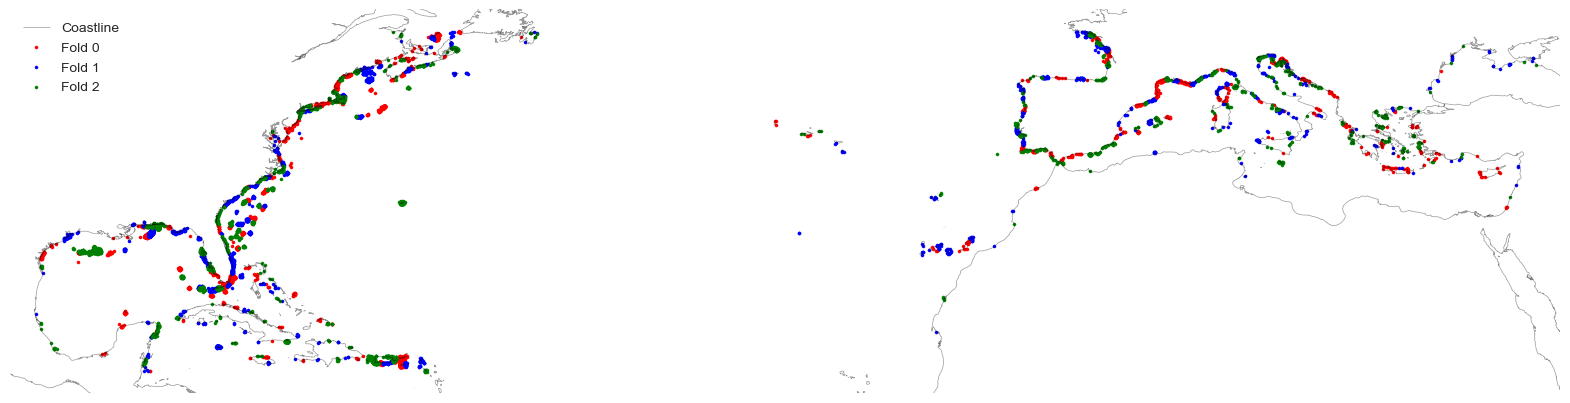

In [25]:
# Visualise folds
visualise_data_on_map(coastline, 
                      [full_gdf[full_gdf["fold_id"] == i] for i in range(NUM_FOLDS)], 
                      ["red", "blue", "green"], 
                      [f"Fold {i}" for i in range(NUM_FOLDS)],
                      coastline_alpha=0.4, plot_bounding_box=False, limit_to_bounding_box=True)

#### 8.2 Train and Evaluate XGBoost Model with Spatial CV
- Need lots of regulation due to very small presence data size
- Due to class imbalance I have set weights per class to combat this
- Trying to reduce overfitting via early stopping, max_depth, row + column sampling per tree, L2 norm, L1 norm
- Generalisation typically improves if using a small learning rate with more trees

In [26]:
def split_train_val_test(X, y, fold_ids, test_fold_id):
    fold_mask = (fold_ids == test_fold_id)
    X_test, y_test = X[fold_mask], y[fold_mask]
    X_train_val, y_train_val = X[~fold_mask], y[~fold_mask]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=0, stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


def calculate_class_weights(y_train):
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    positive_weight = n_neg / max(n_pos, 1)
    return positive_weight


def train_xgboost_model(X_train, y_train, X_val, y_val, positive_weight):
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        n_estimators=2000,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        scale_pos_weight=positive_weight,
        n_jobs=4,
        early_stopping_rounds=50,
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return model


def find_optimal_threshold(model, X_val, y_val):
    """Use F1 Score weighted by class to find optimal threshold."""
    y_probs = model.predict_proba(X_val)[:, 1]
    weights = np.where(y_val == 1, 0.5 / (y_val == 1).sum(), 0.5 / (y_val == 0).sum())
    precision, recall, thresholds = precision_recall_curve(y_val, y_probs, sample_weight=weights)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_idx - 1] if best_idx > 0 else 0.5
    return best_threshold


def evaluate_model(model, X_test, y_test, threshold):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)
    weights = np.where(y_test == 1, 0.5 / (y_test == 1).sum(), 0.5 / (y_test == 0).sum())
    precision = precision_score(y_test, y_pred, sample_weight=weights)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, sample_weight=weights)
    return precision, recall, f1

In [27]:
precisions, recalls, f1_scores, best_thresholds = [], [], [], []
for i in range(NUM_FOLDS):
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, fold_ids, test_fold_id=i)
    pos_weight = calculate_class_weights(y_train)
    xgbm = train_xgboost_model(X_train, y_train, X_val, y_val, pos_weight)
    best_threshold = find_optimal_threshold(xgbm, X_val, y_val)
    precision, recall, f1 = evaluate_model(xgbm, X_test, y_test, best_threshold)
    print("Stopped after {} trees".format(xgbm.best_iteration))

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    best_thresholds.append(best_threshold)

Stopped after 487 trees
Stopped after 16 trees
Stopped after 150 trees


In [28]:
for i in range(NUM_FOLDS):
    print(
        f"Fold {i+1}: P={precisions[i]:.3f}, R={recalls[i]:.3f}, F1={f1_scores[i]:.3f} (thr={best_thresholds[i]:.8f})"
    )

Fold 1: P=0.828, R=0.828, F1=0.828 (thr=0.00227674)
Fold 2: P=0.911, R=0.864, F1=0.887 (thr=0.40749410)
Fold 3: P=0.883, R=0.884, F1=0.883 (thr=0.18056281)


### 9. Evaluation, Final Model and Interpretation
- F1 is generally stable results across folds. Results therefore appear to generalise and we can proceed with training a full model - using all the data - for visualisation and deployment.
  - Decent F1 score (albeit with weighted precision, to combat massive class imbalance + pseudo nature of absence points) consistently of >80%
  - The thresholds and early stopping are rather different - something to look into in the future
- Retrain the model using all of the data, assuming decent generalisation based on the above
  - This is due to very minimal data - every presence data point counts here!
  - Better to hold out a test set from the get-go. This is something I do in the final src code.
- As expected from the earlier feature plots, salinity, sea surface temperature and distance to shore all play highly important roles for the nudibranch!
  - This can be seen in the feature importances
  - Also the partial dependency plots showcase how they have a temperature sweet spot, like a small distance to shore and shallow waters, and enjoy salty conditions
- One should note that the absence data is not true absences, so the true score could in fact be a little higher. In any case, this model appears somewhat useful to define habitable areas for the nudibranch and in general predict their possible true distribution.


In [29]:
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print(f"Mean F1 Score: {mean_f1:.3f} ± {std_f1:.3f}")

Mean F1 Score: 0.866 ± 0.027


In [30]:
X_train, X_val, _, y_train, y_val, _ = split_train_val_test(
    X, y, fold_ids, test_fold_id=1000  # Not a real id, i.e. no test set
)
pos_weight = calculate_class_weights(y_train)
final_model = train_xgboost_model(X_train, y_train, X_val, y_val, pos_weight)
best_threshold = find_optimal_threshold(final_model, X_val, y_val)
print("Final model stopped after {} trees".format(final_model.best_iteration))

Final model stopped after 148 trees


In [31]:
importances = final_model.get_booster().get_score(importance_type="gain")
importance_df = {}
for i, var in enumerate(PREDICTOR_COLS):
    importance_df[var] = importances[f"f{i}"]
importance_df

{'bathymetry': 55.67633819580078,
 'mean_sst': 228.69187927246094,
 'range_sst': 61.105567932128906,
 'mean_salinity': 198.39031982421875,
 'mean_chlorophyll_a': 52.48569107055664,
 'mean_slope': 54.5736083984375,
 'distance_to_shore_m': 129.93153381347656}

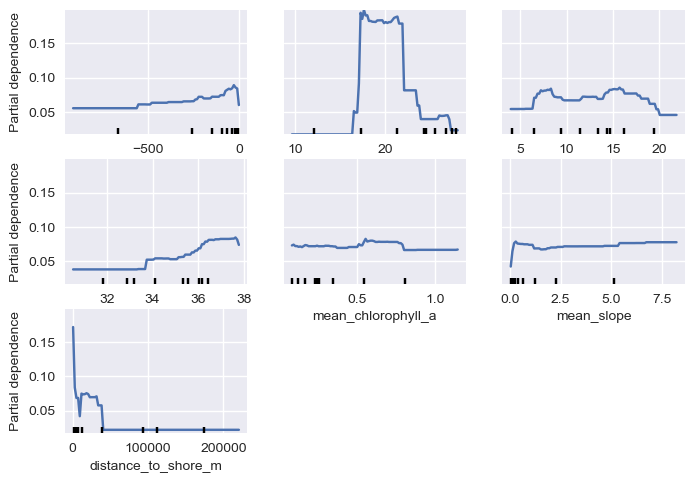

In [32]:
PartialDependenceDisplay.from_estimator(
    final_model,
    X_val,
    features=[i for i in range(len(PREDICTOR_COLS))],
    feature_names=PREDICTOR_COLS,
    kind="average",
)
plt.show()

### 10. Visualisation
- Map out the probability distribution in the accessible area!
  - Seems like I trained somewhat correctly because the observations are all in probability hotspots.
  - Interesting: there are some high probability regions here that have had zero observations (e.g. the entire northern coast of Africa and a few areas in the east coast of the Americas). I'm curious as to what variables specifically drive these high probabilities.

In [33]:
ii, jj = np.where(accessible_area_mask.astype(bool))
lat_arr = lats[ii]
lon_arr = lons[jj]
pts = gpd.GeoSeries(gpd.points_from_xy(lon_arr, lat_arr), crs="EPSG:4326").to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)

coastline_union = coastline.unary_union
distance_to_shore_arr = pts.distance(coastline_union).values

bath_arr   = bath_ds["bathymetry_mean"].values[0][ii, jj]
sst_mean   = mean_sst_ds["thetao_mean"].values[0][ii, jj]
sst_range  = range_sst_ds["thetao_range"].values[0][ii, jj]
sal_mean   = salinity_ds["so_mean"].values[0][ii, jj]
chl_mean   = chloro_ds["chl_mean"].values[0][ii, jj]
slope_arr  = slope_ds["slope"].values[0][ii, jj]
X = np.column_stack([
    bath_arr,
    sst_mean,
    sst_range,
    sal_mean,
    chl_mean,
    slope_arr,
    distance_to_shore_arr
])

valid = ~np.any(np.isnan(X), axis=1)
invalid = np.any(np.isnan(X), axis=1)
probs = final_model.predict_proba(X[valid])[:, 1]

predictions = np.zeros_like(accessible_area_mask, dtype=float) * np.nan
predictions[ii[valid], jj[valid]] = probs
predictions[ii[invalid], jj[invalid]] = np.nan

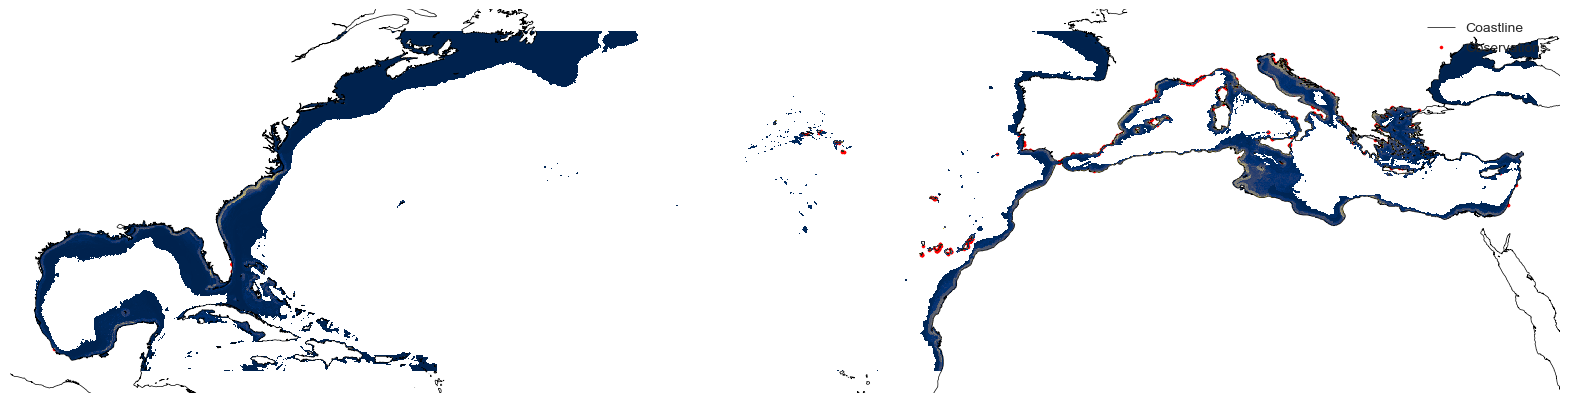

In [34]:
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"],
                      plot_bounding_box=False, limit_to_bounding_box=True, show_plot=False)
mesh = plt.gca().pcolormesh(
    lons, lats, predictions,
    cmap="cividis",
    label="Predicted Suitability"
)
plt.legend()
plt.show()

### 11. Deployment
- Create interactive plot of predictions to put into `./deployment/basic_app.py`

In [35]:
# Downsample grid for Plotly heatmap to avoid memory errors
N = 3
lons_ds = lons[::N]
lats_ds = lats[::N]
predictions_ds = predictions[::N, ::N]

obs_scatter = go.Scatter(
    x=presence_gdf["longitude"],
    y=presence_gdf["latitude"],
    mode="markers",
    marker=dict(size=3, color="red", opacity=0.7),
    name="Observation",
)

suitability_class = np.zeros_like(predictions_ds, dtype=object)
suitability_class[(predictions_ds >= best_threshold)] = "Maybe suitable!"
suitability_class[(predictions_ds < best_threshold)] = "Likely not suitable"
suitability_class[(predictions_ds <= 0) | (np.isnan(predictions_ds))] = "N/A"

custom_probs = np.where(
    np.isnan(predictions_ds), "N/A", np.round(predictions_ds, 2).astype(str)
)
heatmap = go.Heatmap(
    x=lons_ds,
    y=lats_ds,
    z=predictions_ds,
    customdata=custom_probs,
    text=suitability_class,
    hovertemplate=(
        "Lon: %{x:.3f}<br>"
        "Lat: %{y:.3f}<br>"
        "Probability: %{customdata}<br>"
        "Suitability: %{text}<extra></extra>"
    ),
    colorscale="cividis",
    colorbar=dict(
        orientation="h",
        tickvals=[0.1, 0.9],
        ticktext=["Low suitability", "High suitability"],
        tickangle=0,
        ticks="outside",
        thickness=10,
        len=0.3,
        x=0.5,
        xanchor="center",
        y=-0.4,
    ),
    name="Predicted Suitability",
)

fig = go.Figure()
fig.add_trace(heatmap)
fig.add_trace(obs_scatter)

# Add coastline as a Plotly scatter trace
coastline = coastline.to_crs(epsg=4326)
for _, row in coastline.iterrows():
    x, y = row.geometry.xy
    fig.add_trace(
        go.Scatter(
            x=list(x),
            y=list(y),
            mode="lines",
            line=dict(color="black", width=0.5),
            name="Coastline",
            showlegend=False,
            hoverinfo="skip"
        )
    )

fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=1),
    width=600,
    height=300,
    margin=dict(l=0, r=0, t=40, b=0),
)
fig.update_xaxes(range=[min_lon - 2, max_lon + 2], zeroline=False)
fig.update_yaxes(range=[min_lat - 2, max_lat + 2], zeroline=False)

fig.write_html("../img/nudibranch_map.html")

In [36]:
final_model.save_model("../deployment/model.json")
with open("../deployment/feature_names.json", "w") as f:
    json.dump(PREDICTOR_COLS, f)
with open("../deployment/threshold.txt", "w") as f:
    f.write(str(best_threshold))

In [4]:
!cd ../deployment && streamlit run ./basic_app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://192.168.1.14:8502

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
^C
